# House Prices - Advanced Regression Techniques

## GARAGE FEATURES

***

Predict sales prices and practice feature engineering, RFs, and gradient boosting

***

**PROJECT DESCRIPTION:**



**DATA FIELDS**

Here's a brief version of what you'll find in the data description file.

SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.

MSZoning: The general zoning classification

Street: Type of road access

Condition1: Proximity to main road or railroad

Condition2: Proximity to main road or railroad (if a second is present)

OverallCond: Overall condition rating

YearBuilt: Original construction date

GarageType: Garage location

GarageYrBlt: Year garage was built

GarageFinish: Interior finish of the garage

GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

GarageCond: Garage condition

PavedDrive: Paved driveway



# IMPORTS

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# HELPER FUNCTIONS

# LOADING DATA

In [2]:
# data import
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')
y_test_raw = pd.read_csv('sample_submission.csv')

# merge test dataset and sample submission dataset
df_test_raw = pd.merge(df_test_raw, y_test_raw, on = 'Id', how = 'inner')

# merge train and test dataset
df1 = pd.concat([df_train_raw, df_test_raw])

df1.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933.000000
174,1635,60,RL,NaN,8803,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,179007.601964
99,100,20,RL,77.0,9320,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,400,1,2010,WD,Normal,128950.000000
1300,2761,80,RL,83.0,10184,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,183313.601250
492,493,60,RL,105.0,15578,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,New,Partial,172785.000000


In [3]:
df1 =df1[['Condition1', 'Condition2','GarageArea','GarageCars','GarageCond',
         'GarageFinish','GarageQual','GarageType','GarageYrBlt','MSZoning',
         'OverallCond','PavedDrive','Street','YearBuilt','SalePrice']]

# DATA DESCRIPTION

## DATA TYPES

In [4]:
#shape
df1.shape

(2919, 15)

In [5]:
# columns
df1.columns

Index(['Condition1', 'Condition2', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'MSZoning',
       'OverallCond', 'PavedDrive', 'Street', 'YearBuilt', 'SalePrice'],
      dtype='object')

In [6]:
# data types
for f in df1:
    a = abs(len(f) - 20)
    print(f + (" " * a)  + str(df1[f].dtypes))

Condition1          object
Condition2          object
GarageArea          float64
GarageCars          float64
GarageCond          object
GarageFinish        object
GarageQual          object
GarageType          object
GarageYrBlt         float64
MSZoning            object
OverallCond         int64
PavedDrive          object
Street              object
YearBuilt           int64
SalePrice           float64


## MISSING VALUES

In [7]:
# Missing values
missing = df1.isnull().sum()
aux = pd.DataFrame(missing[missing > 0].sort_values(ascending = False), columns = ['variables'])

# count + percentage
aux['percentage'] = aux['variables'].apply(lambda x : (x / (df1.shape[0]) * 100))

aux

,variables,percentage
GarageYrBlt,159,5.447071
GarageQual,159,5.447071
GarageFinish,159,5.447071
GarageCond,159,5.447071
GarageType,157,5.378554
MSZoning,4,0.137033
GarageCars,1,0.034258
GarageArea,1,0.034258


In [8]:
# dropping missing values > 40%
#df1 = df1.drop(columns=aux[aux['percentage'] > 40].index)

# ffill missing values < 1
df1.loc[:, aux[aux['percentage'] < 1].index] = df1.loc[:, aux[aux['percentage'] < 1].index].fillna(method = 'ffill') 

# fillna - mode
aux2 = df1.loc[:, aux[(aux['percentage'] > 1) & (aux['percentage'] < 17)].index]

for c in aux2.columns:
    df1[c].fillna(df1[c].mode()[0], inplace=True)

# Missing values
missing = df1.isnull().sum()
aux = pd.DataFrame(missing[missing > 0].sort_values(ascending = False), columns = ['variables'])

aux

,variables


# DIMENSIONS ANALYSIS

In [9]:
# numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### Numerical Features

In [10]:
cols = num_attributes.columns

def funcao_value_counts():
    for d in num_attributes[cols]:
        print((num_attributes[d].value_counts(normalize = True) * 100).sort_values(ascending = False))
        
funcao_value_counts()


0.0       5.412813
576.0     3.323056
440.0     3.288798
240.0     2.363823
484.0     2.329565
            ...   
753.0     0.034258
815.0     0.034258
325.0     0.034258
1390.0    0.034258
803.0     0.034258
Name: GarageArea, Length: 603, dtype: float64
2.0    54.607742
1.0    26.584447
3.0    12.812607
0.0     5.412813
4.0     0.548133
5.0     0.034258
Name: GarageCars, dtype: float64
2005.0    10.311751
2006.0     3.939705
2007.0     3.939705
2004.0     3.391572
2003.0     3.151764
            ...    
1919.0     0.034258
1895.0     0.034258
2207.0     0.034258
1908.0     0.034258
1896.0     0.034258
Name: GarageYrBlt, Length: 103, dtype: float64
5    56.354916
6    18.191161
7    13.360740
8     4.933196
4     3.460089
3     1.712915
9     1.404591
2     0.342583
1     0.239808
Name: OverallCond, dtype: float64
2005    4.864680
2006    4.727646
2007    3.734156
2004    3.391572
2003    3.014731
          ...   
1902    0.034258
1898    0.034258
1896    0.034258
1882    0.034258
1872

### Categorical Features

In [11]:
cols = cat_attributes.columns

def funcao_value_counts():
    for d in cat_attributes[cols]:
        print((cat_attributes[d].value_counts(normalize = True) * 100).sort_values(ascending = False))
        
funcao_value_counts()


Norm      86.022610
Feedr      5.618362
Artery     3.151764
RRAn       1.712915
PosN       1.336074
RRAe       0.959233
PosA       0.685166
RRNn       0.308325
RRNe       0.205550
Name: Condition1, dtype: float64
Norm      98.972251
Feedr      0.445358
Artery     0.171292
PosN       0.137033
PosA       0.137033
RRNn       0.068517
RRAn       0.034258
RRAe       0.034258
Name: Condition2, dtype: float64
TA    96.368619
Fa     2.535115
Gd     0.513875
Po     0.479616
Ex     0.102775
Name: GarageCond, dtype: float64
Unf    47.584789
RFn    27.783487
Fin    24.631723
Name: GarageFinish, dtype: float64
TA    94.655704
Fa     4.248030
Gd     0.822199
Po     0.171292
Ex     0.102775
Name: GarageQual, dtype: float64
Attchd     64.405618
Detchd     26.687222
BuiltIn     6.372045
Basment     1.233299
2Types      0.787941
CarPort     0.513875
Name: GarageType, dtype: float64
RL         77.663583
RM         15.827338
FV          4.761905
RH          0.890716
C (all)     0.856458
Name: MSZoning, dt

# DESCRIPTIVE STATISTICS

## Numerical Attributes

In [12]:
# Central Tendency - mean, median, mode
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
#ct3 = pd.DataFrame(num_attributes.apply(mode)).T

# Dipersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

# concat
t = pd.concat([ct1, ct2, d1, d2, d3, d4]).T.reset_index()
t.columns = ['attributes', 'mean', 'median', 'std', 'min', 'max', 'range']
t



,attributes,mean,median,std,min,max,range
0,GarageArea,472.712573,480.000000,215.498763,0.0,1488.0,1488.0
1,GarageCars,1.766016,2.000000,0.762065,0.0,5.0,5.0
2,GarageYrBlt,1979.577938,1984.000000,25.601272,1895.0,2207.0,312.0
3,OverallCond,5.564577,5.000000,1.112940,1.0,9.0,8.0
4,YearBuilt,1971.312778,1973.000000,30.286252,1872.0,2010.0,138.0
5,SalePrice,180052.854647,176734.841494,57371.735902,34900.0,755000.0,720100.0


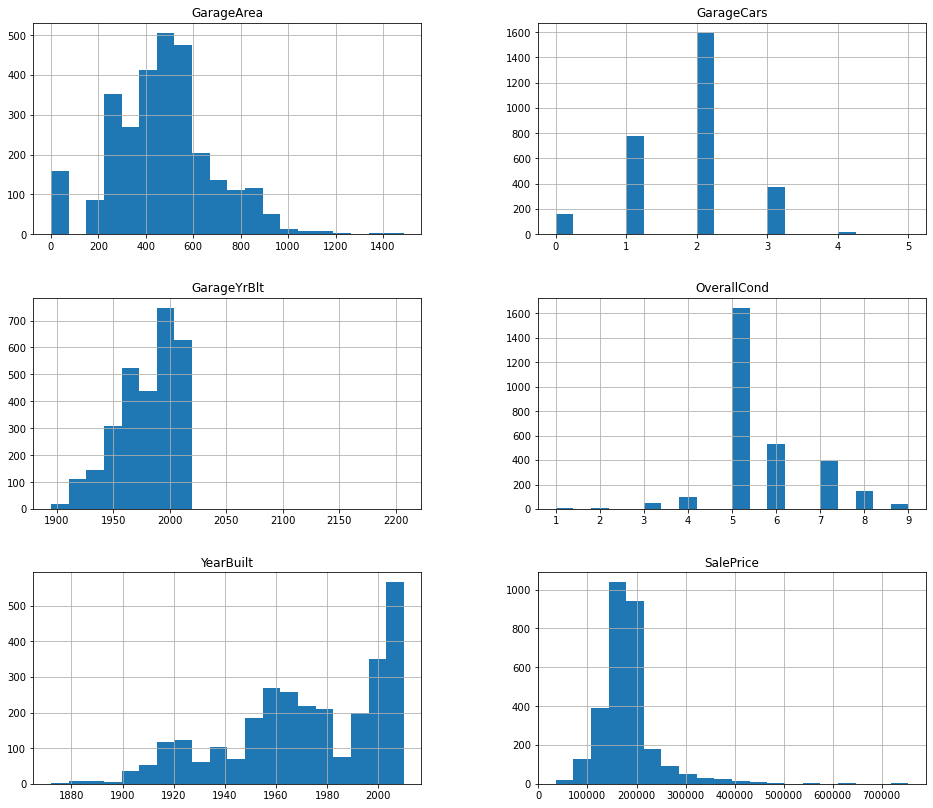

In [13]:
df1[num_attributes.columns].hist(bins = 20, figsize=(16,14));


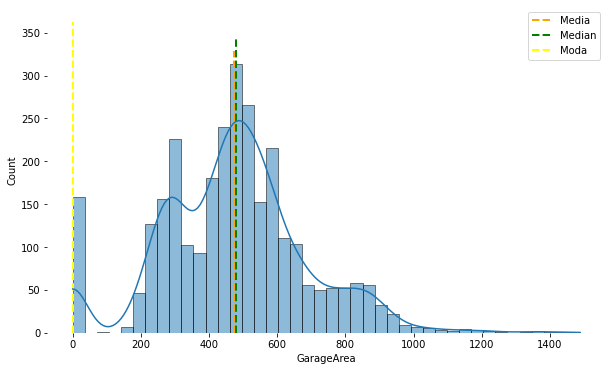

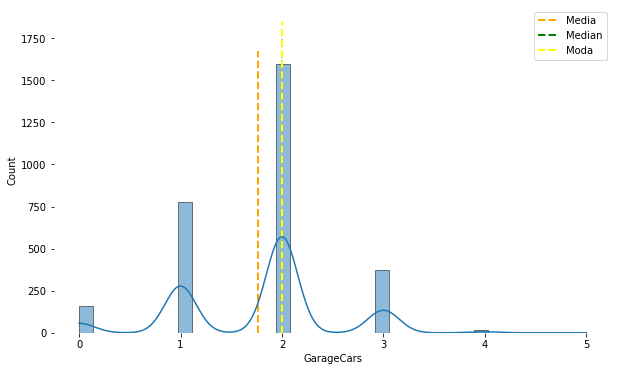

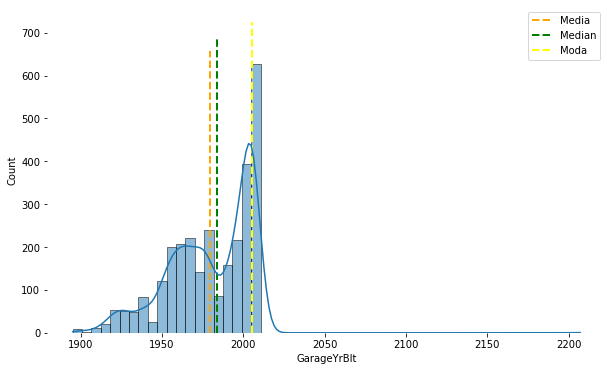

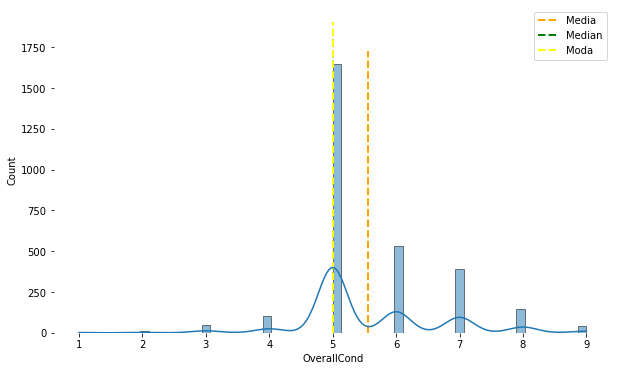

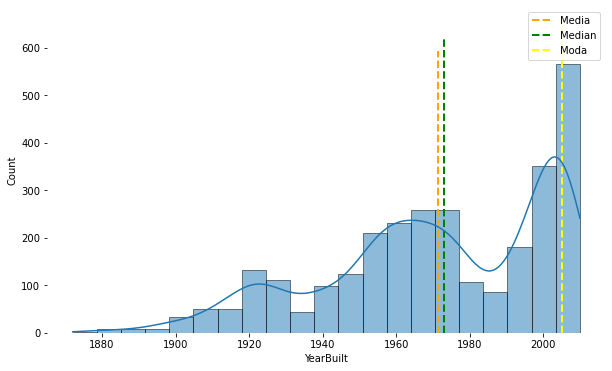

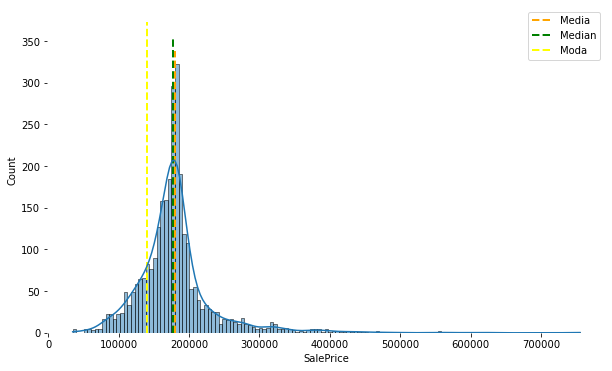

In [14]:
for a in df1[num_attributes.columns]:
    
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(df1[num_attributes.columns][a], kde = True, linewidth = 0.5)
    sns.despine(bottom = True, left = True)
    
    plt.vlines( x = df1[num_attributes.columns][a].mean(), linewidth = 2, color = 'orange',
              ymin = 0, ymax = ax.get_ylim()[1],
              label = 'Media', linestyle = '--')
    
    plt.vlines( x = df1[num_attributes.columns][a].median(), linewidth = 2, color = 'green',
              ymin = 0, ymax = ax.get_ylim()[1],
              label = 'Median', linestyle = '--')
    
    plt.vlines( x = df1[num_attributes.columns][a].mode()[0], linewidth = 2, color = 'yellow',
              ymin = 0, ymax = ax.get_ylim()[1],
              label = 'Moda', linestyle = '--')
    
    
    plt.legend()
    

**1. YEAR BUILT**

**1.1**: Most of the houses were built in 20's years

**1.2**: The second period were in 1960

**1.3**: The third period were in 20's

***

**2. GARAGE AREA**

**2.1** The most commom garage area is about 400 - 600m

**2.2** Houses in this dataset have, usually, 2 parking spaces

***

**3. Overall Condition**

**3.1** Few houses are in bad conditions 

**3.2** Few houses are in excellent conditions

**3.3.** Most of houses are in "avarage" condition

***

**4** Garage x houses built

**4.1** There's many houses built in the early's year 60 (or even earlier), while year garage built attribute, is often, more recently. 


***

## Categorical Attributes

In [15]:
df1[cat_attributes.columns].apply(lambda x: x.unique().shape[0])

Condition1      9
Condition2      8
GarageCond      5
GarageFinish    3
GarageQual      5
GarageType      6
MSZoning        5
PavedDrive      3
Street          2
dtype: int64

In [16]:
def cat_boxplot(variavel):
    plt.figure(figsize=(12, 5))
    ax = sns.boxplot(data = df1[[variavel, 'SalePrice']],
                 y = 'SalePrice', x = variavel,hue = variavel, dodge = False)
    sns.despine(bottom = True, left = True);

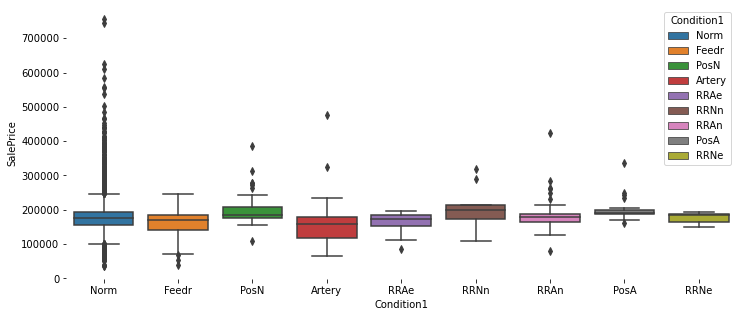

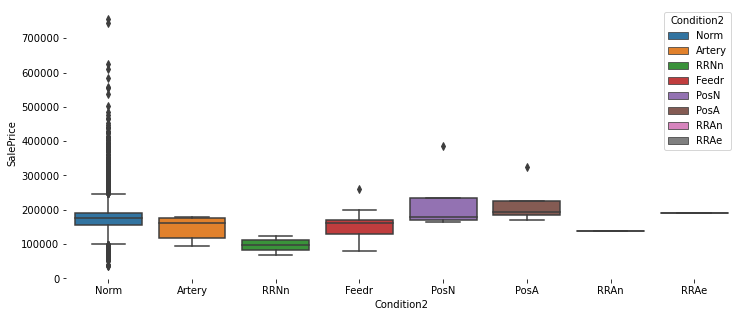

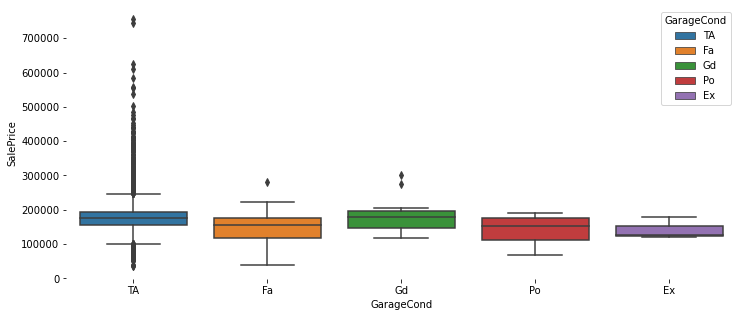

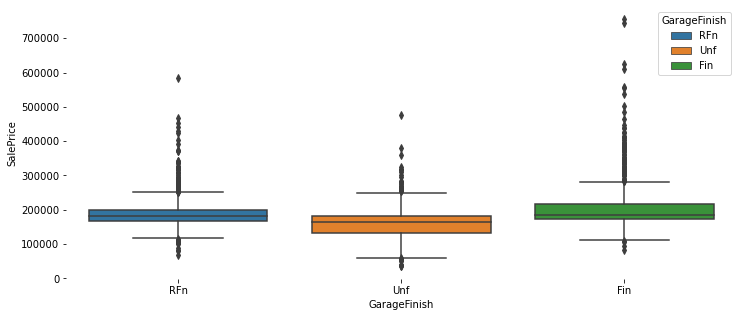

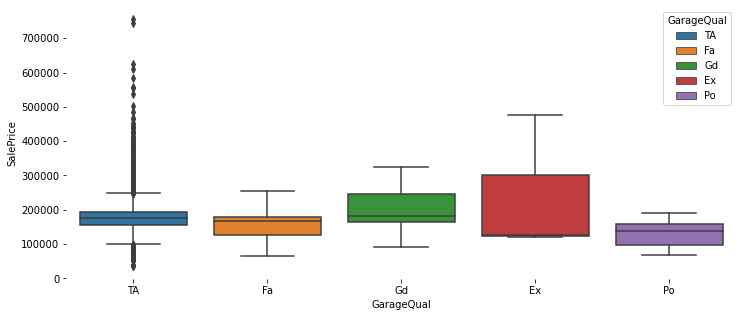

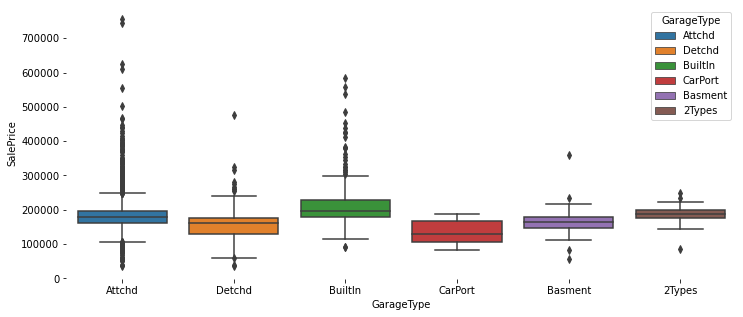

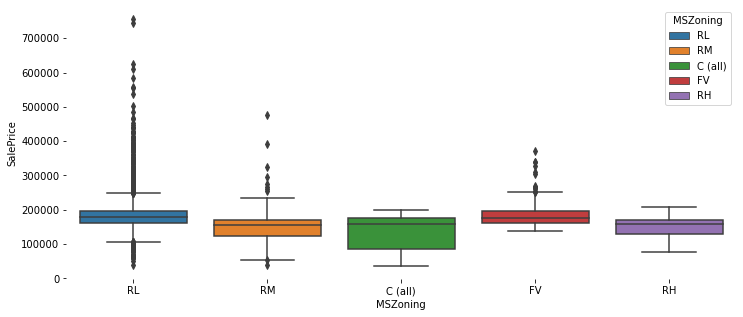

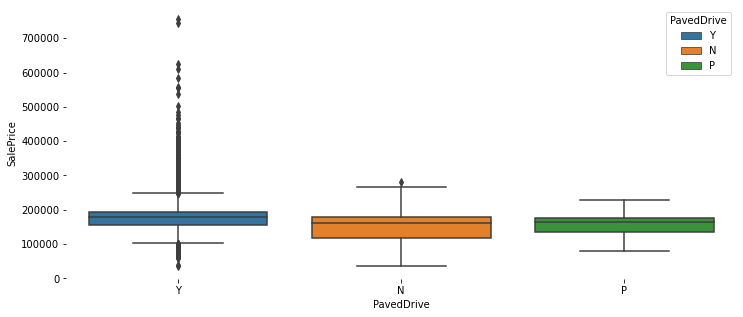

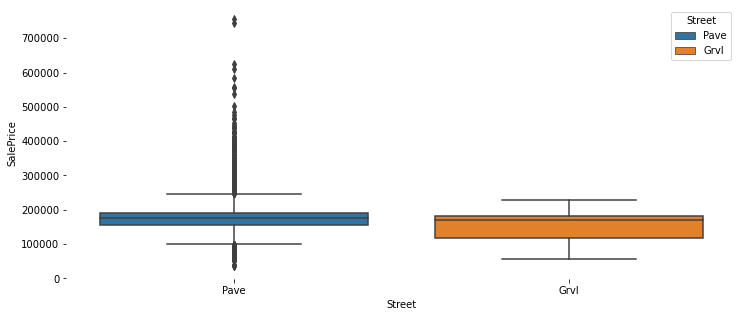

In [17]:
for g in df1[cat_attributes.columns]:
    cat_boxplot(g)

**1. Condition1**

**1.1** Normal conditions has more outliers

**1.2** Houses located near arterial street have its median higher

**1.3** Houses Near positive off-site feature--park, greenbelt have its median lower

***

**2. Garage Condition**

**2.1** As usual, garages in normal conditions have more outliers comparing to its price.

**2.2** Houses with poor garagem condition have the median measure lower

***
**3. GarageFinish: Interior finish of the garage**

**3.1** garages with Finishied interior are more expensive.

***
**4. Garage Quality**

**4.1** Excelente garage quality increases extremely median measure of house's price.


# FEATURE ENGEENIRING

# EXPLORATORY DATA ANALYSIS

<img src="https://i.ibb.co/KrzJTGQ/Screenshot-at-mai-18-22-17-47.png" alt="Screenshot-at-mai-18-22-17-47" width="681" height="550" data-load="full" style="">

## Garage Area

### Houses with higher garage area cost more

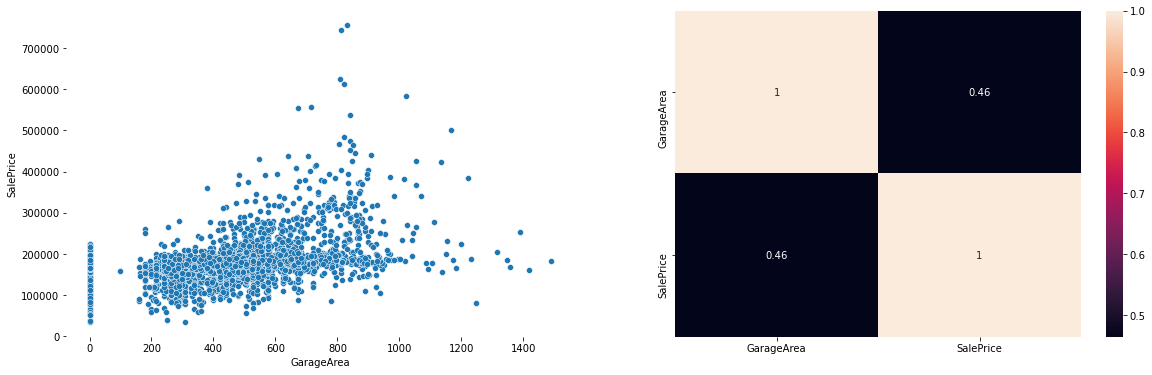

In [18]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data = df1[['GarageArea', 'SalePrice']], x = 'GarageArea', y = 'SalePrice')
sns.despine(bottom = True, left = True)

plt.subplot(1, 2, 2)
sns.heatmap(df1[['GarageArea', 'SalePrice']].corr(method='pearson'), annot= True);


### Garages in excellent conditions category cost more

***

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

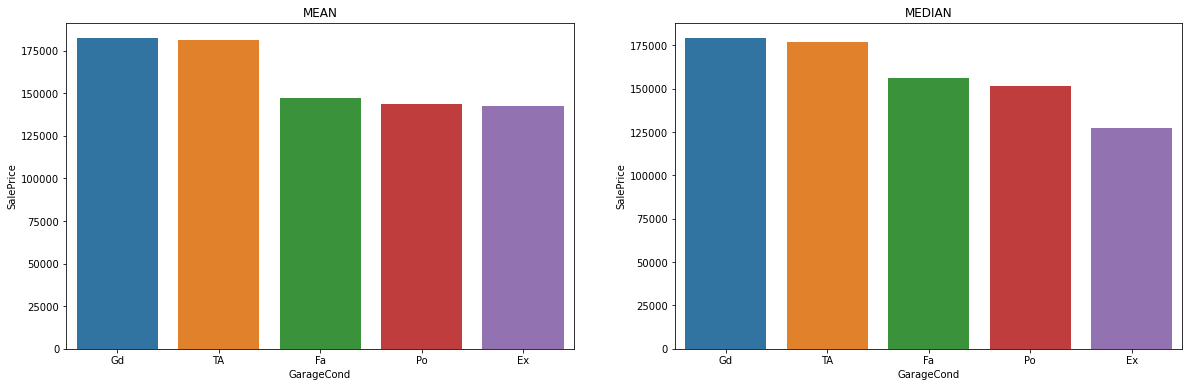

In [33]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

order = df1[['GarageCond', 'SalePrice']].groupby('GarageCond').mean().sort_values('SalePrice',ascending = False).index

sns.barplot(data = df1[['GarageCond', 'SalePrice']].groupby('GarageCond', as_index = False).mean(),
           x = 'GarageCond', y='SalePrice',
           order = order)
plt.title('MEAN')

plt.subplot(1, 2, 2)
order = df1[['GarageCond', 'SalePrice']].groupby('GarageCond').median().sort_values('SalePrice',ascending = False).index

sns.barplot(data = df1[['GarageCond', 'SalePrice']].groupby('GarageCond', as_index = False).median(),
           x = 'GarageCond', y='SalePrice',
           order = order)
plt.title('MEDIAN');


### Houses with unfinished garages cost less

***

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

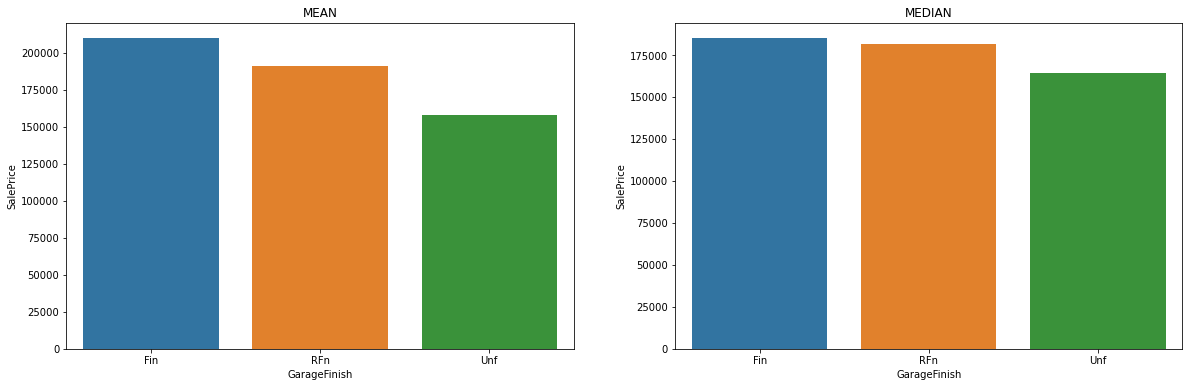

In [37]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

order = df1[['GarageFinish', 'SalePrice']].groupby('GarageFinish').mean().sort_values('SalePrice',ascending = False).index

sns.barplot(data = df1[['GarageFinish', 'SalePrice']].groupby('GarageFinish', as_index = False).mean(),
           x = 'GarageFinish', y='SalePrice',
           order = order)
plt.title('MEAN')

plt.subplot(1, 2, 2)
order = df1[['GarageFinish', 'SalePrice']].groupby('GarageFinish').median().sort_values('SalePrice',ascending = False).index

sns.barplot(data = df1[['GarageFinish', 'SalePrice']].groupby('GarageFinish', as_index = False).median(),
           x = 'GarageFinish', y='SalePrice',
           order = order)
plt.title('MEDIAN');


### Houses which was remodeled in order to build a garage cost more

***

- YearBuilt: Original construction date

- GarageYrBlt: Year garage was built

In [52]:
aux = df1[['YearBuilt', 'GarageYrBlt', 'SalePrice']]
aux['diff'] = aux[['YearBuilt', 'GarageYrBlt']].apply(lambda x: x['GarageYrBlt'] - x['YearBuilt'], axis = 1)

aux


,YearBuilt,GarageYrBlt,SalePrice,diff
0,2003,2003.0,208500.000000,0.0
1,1976,1976.0,181500.000000,0.0
2,2001,2001.0,223500.000000,0.0
3,1915,1998.0,140000.000000,83.0
4,2000,2000.0,250000.000000,0.0
...,...,...,...,...
1454,1970,2005.0,167081.220949,35.0
1455,1970,1970.0,164788.778231,0.0
1456,1960,1960.0,219222.423400,0.0
1457,1992,2005.0,184924.279659,13.0


In [61]:
aux[aux['diff'] > 200] = 0

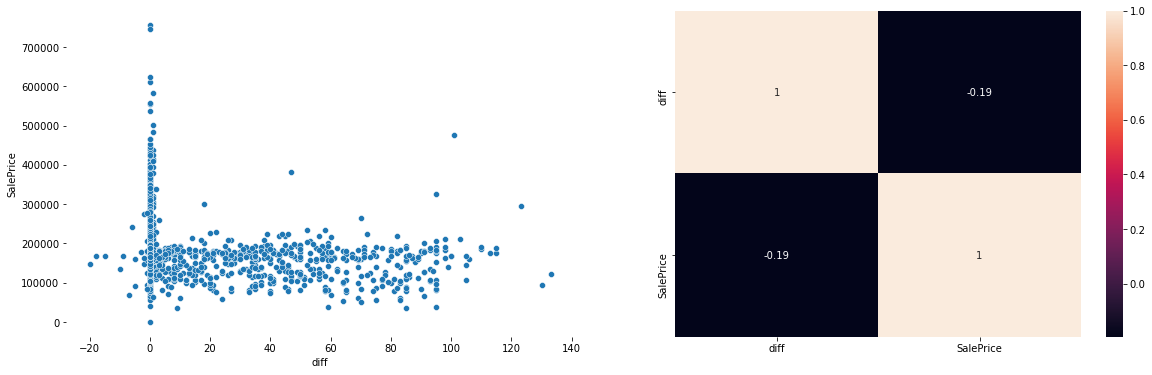

In [62]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data = aux[['diff', 'SalePrice']], x = 'diff', y = 'SalePrice')
sns.despine(bottom = True, left = True)

plt.subplot(1, 2, 2)
sns.heatmap(aux[['diff', 'SalePrice']].corr(method='pearson'), annot= True);


### Houses with carport garages cost less

### Houses with detached garages cost less

### Modern houses (recently year built) cost more